In [4]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import pandas as pd
# from hyperopt import Trials, STATUS_OK, tpe
# from hyperas import optim
# from hyperas.distributions import choice, uniform, conditional
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras import metrics
from keras.callbacks import TensorBoard
from nn_models import *
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
HTML('''<script> code_show_err=false;  function code_toggle_err() {if (code_show_err){$('div.output_stderr').hide();} else {$('div.output_stderr').show();}code_show_err = !code_show_err} $( document ).ready(code_toggle_err);</script>To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Using TensorFlow backend.


# Get Data

In [2]:
# window_size = 6
# batch_size = 20
# data_ = make_clean_data(window_size,batch_size=0,multiplier=1)
# time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100
# print(len(data_['y_train_c']))

In [3]:
def data():
    """
    Data providing function:

    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    """
    data_ = make_clean_data(6, batch_size=100, multiplier=1)
    x_train, y_train, x_test, y_test =  data_['x_train_c'], data_['y_train_c'], data_['x_test_c'], data_['y_test_c']
    return x_train, y_train, x_test, y_test

def model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
        
    """
    window_size=6
    filter_length=3
    original_dim = 15
    nb_input_series=original_dim
    nb_outputs=original_dim
    nb_filter=64
    batch_size = 128
    
    inputs = Input(shape=(6, original_dim), name='Input')
    conv1 = Conv1D(name='Conv1', 
                   filters={{choice([8,16,32,64,96,128])}}, 
                   kernel_size={{choice([1,2,3,4,5,6])}}, 
                   activation={{choice(['relu','elu'])}}, 
                   input_shape=(window_size, nb_input_series)
                  )(inputs)

    if conditional({{choice(['norm', 'no_norm'])}}) == 'norm':
        conv1 = BatchNormalization()(conv1)
        
    flat1 = Flatten(name='Flatten')(conv1)
    output = Dense(nb_outputs, activation={{choice(['relu','elu'])}},name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'

    conv_encoder = Model(inputs,flat1)
    conv_model = Model(inputs,output)
    conv_model.compile(loss='mse', optimizer={{choice(['adam','rmsprop'])}}, metrics=['mae'])


    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
    conv_model_data = conv_model.fit(
        x=x_train, 
        y=y_train, 
        verbose=0, 
        epochs=1000, 
        batch_size=128, 
        validation_data=(x_test, y_test), 
        callbacks=[reduce_lr,early_stop])
    
    loss, acc = conv_model.evaluate(x_test, y_test, verbose=0, batch_size=batch_size)
    print('Test val min loss:', loss)
    return {'loss': loss, 'status': STATUS_OK, 'model': conv_model}

best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                     notebook_name='Hyperop Experiments')
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test, batch_size=128))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform, conditional
except:
    pass

try:
    from keras.models import *
except:
    pass

try:
    from keras.layers import *
except:
    pass

try:
    from keras.optimizers import *
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import metrics
except:
    pass

try:
    from keras.callbacks import TensorBoard
except:
    pass

try:
    from nn_models import *
except:
    pass

try:
    from IPython.display impo

/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
Test val min loss: 0.0249344284998
Test val min loss: 0.0137189729595
Test val min loss: 0.0129257883504
Test val min loss: 0.0133942095687
Test val min loss: 0.0129178778662
(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
Evalutation of best performing model:
 128/3600 [>.............................] - ETA: 0s[0.012917877866162194, 0.04840795073244307]
Best performing model chosen hyper-parameters:
{'activation': 1, 'activation_1': 1, 'conditional': 0, 'filters': 3, 'kernel_size': 4, 'optimizer': 1}


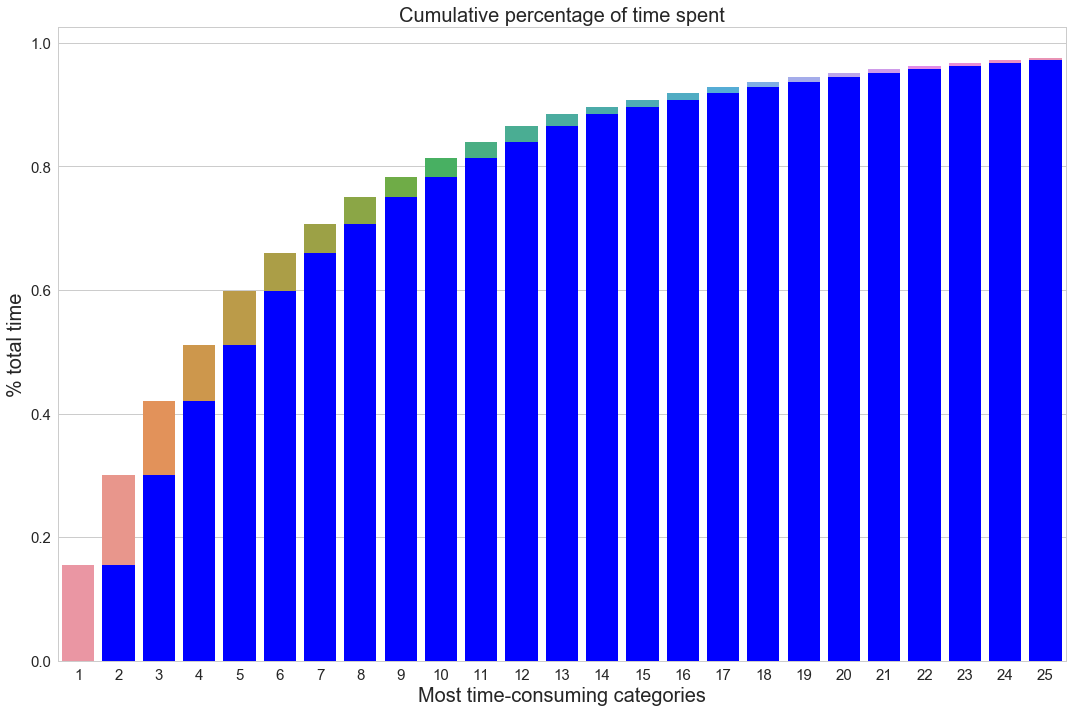

In [8]:
filename = 'data.pickle'
with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
    data = pickle.load(f)
        
#Plot distribution of time across activity sorted by most popular
ts_np1 = data.app_cdf[:25]
x = np.arange(len(ts_np1))+1
sns.set_style("whitegrid")
df = pd.DataFrame.from_dict({'x' : x, 'y' : ts_np1})
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(x='x', y='y', data=df)
plt.bar(x, ts_np1, alpha=1, color='blue')
plt.ylabel("% total time",fontsize = 20)
plt.xlabel("Most time-consuming categories",fontsize = 20)
plt.title("Cumulative percentage of time spent",fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.savefig('time_spent.png', format='png', dpi=1000)